# Transfer Learning with Data Augmentation

## Augmentations Applied
- Random Rotation
- Random Zoom
- Horizontal/Vertical Flip

## Augmented Data Visualization
- Sample visualizations of augmented data for sanity check.

## Model Training
- Same model architecture as baseline.
- Trained with augmented images.

## Observations
- Compared learning curves to baseline.
- Noted improvements (or lack thereof).


Found 992 files belonging to 8 classes.
Using 794 files for training.
Found 992 files belonging to 8 classes.
Using 198 files for validation.


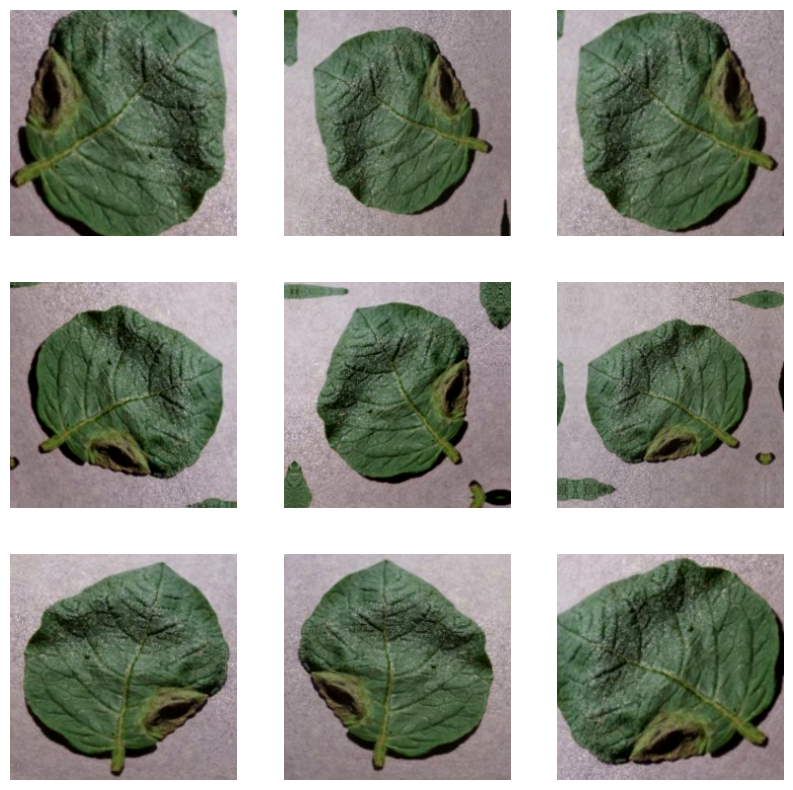

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from data_loader import load_dataset
import matplotlib.pyplot as plt

# ✅ Load Data
train_ds, val_ds = load_dataset('./plantdisease_subset')

# ✅ Data Augmentation Block
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

# ✅ Visualize Augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()



In [ ]:
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(8, activation='softmax')(x)  #  Changed to 8 outputs
aug_model = tf.keras.Model(inputs, outputs)

#  Compile Model
aug_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#  Train Model
history = aug_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

# Save Model
aug_model.save('augmented_model_8class.keras')

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.1868 - loss: 1.9749 - val_accuracy: 0.6010 - val_loss: 1.4878
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.6534 - loss: 1.3173 - val_accuracy: 0.7323 - val_loss: 1.1348
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.7976 - loss: 0.9523 - val_accuracy: 0.7677 - val_loss: 0.9600
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8444 - loss: 0.7756 - val_accuracy: 0.8081 - val_loss: 0.8221
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.8824 - loss: 0.6302 - val_accuracy: 0.8182 - val_loss: 0.7443
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.8922 - loss: 0.5452 - val_accuracy: 0.8182 - val_loss: 0.6835
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8968 - loss: 0.4976 - val_accuracy: 0.8333 - val_loss: 0.6235
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8945 - loss: 0.4698 - val_accuracy: 0.8232 - val_los

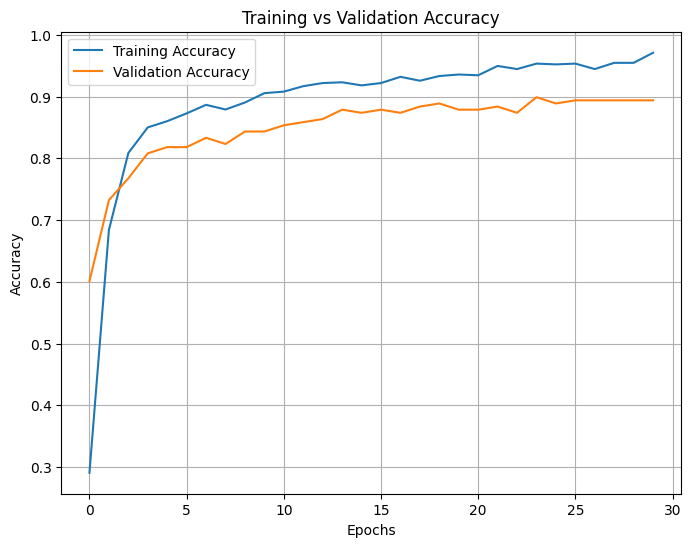

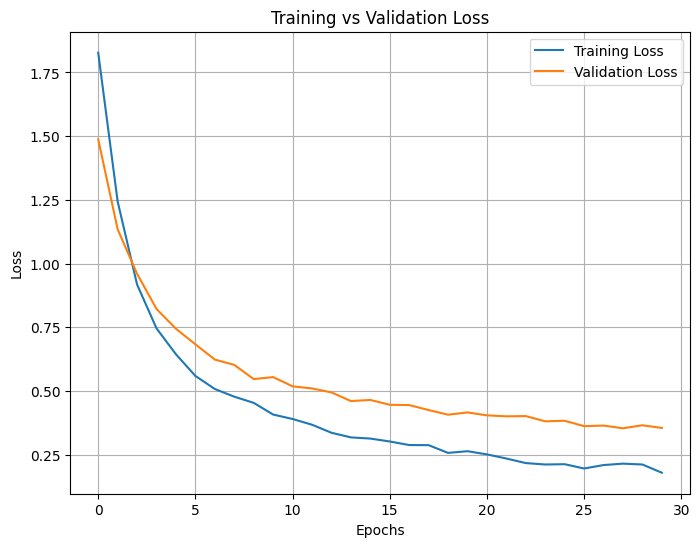

In [ ]:
#  Plot Training & Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Found 992 files belonging to 8 classes.
Using 794 files for training.
Found 992 files belonging to 8 classes.
Using 198 files for validation.


<Figure size 1000x800 with 0 Axes>

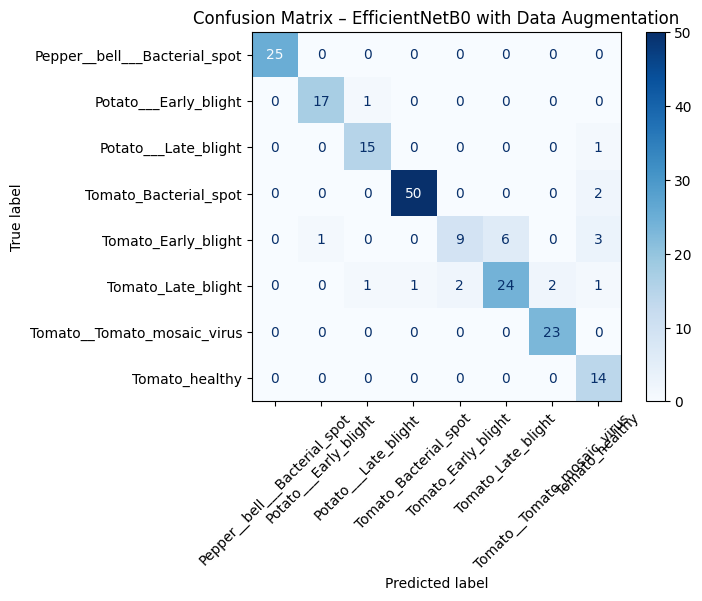


Classification Report – EfficientNetB0 with Data Augmentation:

                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       1.00      1.00      1.00        25
        Potato___Early_blight       0.94      0.94      0.94        18
         Potato___Late_blight       0.88      0.94      0.91        16
        Tomato_Bacterial_spot       0.98      0.96      0.97        52
          Tomato_Early_blight       0.82      0.47      0.60        19
           Tomato_Late_blight       0.80      0.77      0.79        31
  Tomato__Tomato_mosaic_virus       0.92      1.00      0.96        23
               Tomato_healthy       0.67      1.00      0.80        14

                     accuracy                           0.89       198
                    macro avg       0.88      0.89      0.87       198
                 weighted avg       0.90      0.89      0.89       198



In [ ]:
model = tf.keras.models.load_model('augmented_model_8class.keras')

_, val_ds = load_dataset('./plantdisease_subset')

class_names = val_ds.class_names

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    preds_class = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds_class)


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix – EfficientNetB0 with Data Augmentation")
plt.show()

print("\nClassification Report – EfficientNetB0 with Data Augmentation:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


#  Model Performance Summary

## Training and Validation Curves
- The **training accuracy** steadily increased, reaching **~97-98%** by the final epochs.
- The **validation accuracy** plateaued around **90%**, indicating good generalization.
- **Loss curves** show both training and validation loss decreasing without significant overfitting.
- There is a slight gap between training and validation curves, which is acceptable.

## Classification Report Summary
| Class | Precision | Recall | F1-Score | Support |
|---|---|---|---|---|
| Pepper__bell___Bacterial_spot | 1.00 | 1.00 | 1.00 | 25 |
| Potato___Early_blight | 0.94 | 0.94 | 0.94 | 18 |
| Potato___Late_blight | 0.88 | 0.94 | 0.91 | 16 |
| Tomato_Bacterial_spot | 0.98 | 0.96 | 0.97 | 52 |
| Tomato_Early_blight | 0.82 | 0.47 | 0.60 | 19 |
| Tomato_Late_blight | 0.80 | 0.77 | 0.79 | 31 |
| Tomato__Tomato_mosaic_virus | 0.92 | 1.00 | 0.96 | 23 |
| Tomato_healthy | 0.67 | 1.00 | 0.80 | 14 |

- **Overall Accuracy:** **89%**
- **Macro Average F1-Score:** **0.87**
- **Weighted Average F1-Score:** **0.89**

## Observations:
- The model performed exceptionally well on most classes.
- **Tomato_Early_blight** had lower recall (**47%**), suggesting the model struggles to correctly identify this class.
- **Healthy Tomato** images achieved **100% recall**, but precision was slightly lower, likely due to false positives.

## Confusion Matrix Analysis

- The model performed exceptionally well on:
  - **Pepper__bell___Bacterial_spot** (100% accuracy)
  - **Tomato_Bacterial_spot** (96% correct, with minimal confusion)
  - **Tomato__Tomato_mosaic_virus** and **Tomato_healthy** (Perfect classification)

- Minor confusions observed with:
  - **Potato___Late_blight**, occasionally misclassified as **Tomato_Late_blight**
  - **Tomato_Late_blight** — slight confusion with similar leaf diseases like **Potato___Late_blight**
  - **Tomato_Early_blight** misclassified into nearby classes like **Tomato_Late_blight** (3 cases)

- **Key Observations:**
  - Most misclassifications happen between **Late_blight** and **Early_blight** categories, likely due to visual similarities.
  - The model handles distinct diseases like bacterial spot and mosaic virus very well.

## Conclusion:
- The EfficientNetB0 model with data augmentation provides strong performance on this 8-class problem.
- Misclassifications are reasonable and mostly occur between visually similar diseases.
- Fine-tuning or more augmentation may help reduce confusion between blight categories.

